This notebook aims at re-implementing the paper  [*Attentive state-space modelling of disease progression*](https://papers.nips.cc/paper/2019/file/1d0932d7f57ce74d9d9931a2c6db8a06-Paper.pdf), which proposes a deep state-space model with attention machanism and a approximate inference method to proceed model training. Meanwhile, we also carry out some extra evaluation of the model particularly on posterior sampling and also attention mechanism. 

#Attentive state-space model re-implementation

##Package needed

In [9]:
import numpy as np
import torch
import copy
import math
import seaborn as sns
import os
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Multinomial

from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import multivariate_normal


from __future__ import absolute_import, division, print_function
get_ipython().magic('matplotlib inline')
import warnings
warnings.filterwarnings("ignore")

##connect to google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

##helper functions

In [2]:
def state_to_array(state_index, number_of_states):
    """
    function that transfer array with index into one-hot vector
    """
    state_array = np.zeros(number_of_states)
    state_array[state_index] = 1

    return state_array


def padd_data(X, padd_length):
    """
    X : list of unpadded data

    return : list of padded data
    """
    X_padded = []
    for i in range(len(X)):
        if X[i].shape[0] < padd_length:
            if len(X[i].shape) > 1:     #two dimension
                pad_zero = np.zeros( ((padd_length-X[i].shape[0]), X[i].shape[1])  )
                pad_concate = np.array(np.vstack((np.array(X[i]), pad_zero)))
                X_padded.append(pad_concate)
            else:
                pad_zero = np.zeros((padd_length-X[i].shape[0], 1))
                pad_concate = np.array(np.vstack( (np.array(X[i]).reshape((-1,1)), pad_zero)))
                X_padded.append(pad_concate)
        elif X[i].shape[0] == padd_length:
            X_padded.append(X[i])

        else:
            raise ValueError('data with length longer than the maximum has occured')
    
    return X_padded
                #temp_pad = np.vstack(np.array(X[i]), np.zeros( ((padd_length-X[i].shape[0]), X[i].shape[1])   ))

def get_transition(state_array, num_states):
    """
    state_array: an array showing the sequenve of indices of states
    num_states: total number of states
    return
    trans_matrix: unnormalised empirical transition matrix computed from the state_array
    each_staet: a list of how many number of each states
    """

    #print('state_array', state_array)
    #print('num states', num_states)

    trans_matrix = np.zeros((num_states, num_states))
    each_state = [np.sum((state_array == k)*1) for k in range(num_states)]      #list, number of each stae in the array

    for i in range(num_states):
        #print('i = ', i)
        temp_where_states = np.where(state_array==i)[0]
        #print('temp_where', temp_where_states)
        where_states = temp_where_states[temp_where_states<len(state_array)-1]      #discard the last one (ending node)
        #print('where', where_states)

        after_states = [state_array[where_states[j]+1] for j in range(len(where_states))]

        trans_matrix[i,:]  = np.array([np.where(np.array(after_states) == k)[0].shape[0] for k in range(num_states)])

    return trans_matrix, each_state

#rand_unif_init_mag = 0.02
#trunc_norm_init_std = 1e-4

def init_lstm_wt(lstm, seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    for name,_ in lstm.named_parameters():
        if 'weight' in name:
            wt = getattr(lstm, name)
            torch.nn.init.xavier_uniform_(wt.data)
            #wt.data = wt.data.uniform_(-rand_unif_init_mag)
        elif 'bias' in name:
            bias = getattr(lstm, name)
            #n = bias.size(0)
            #start, end = n // 4, n//2
            bias.data = bias.data.fill_(0.)


def init_linear_wt(linear, seed = None):
    if seed is not None:
        torch.manual_seed(seed)

    stdv = 1. / math.sqrt(linear.weight.size(1))
    linear.weight.data.uniform_(-stdv, stdv)
    if linear.bias is not None:
        linear.bias.data.uniform_(-stdv, stdv)

        
def init_wt_normal(wt, seed=None):
    return
    if seed is not None:
        torch.mamual_seed(seed)
    wt.data = wt.data.normal_(std = trunc_norm_init_std)



def get_cuda(tensor):
    if torch.cuda.is_available():
        tensor = tensor.cuda()
    return tensor

def save_model(iter, model, trainer):
    """
    iter: the current number of iteration
    model: the model to be saved
    trainer: the optimiser to be saved

    save_model_path is pre-defined
    """

    save_path = save_model_path + "/%07d.tar" % iter
    torch.save({
        "iter": iter ,
        "model_dict": model.state_dict(),
        "trainer_dict": trainer.state_dict()
    }, save_path)

def load_model(new_model, iter, lr):
    """
    iter : name of the model
    """

    model = get_cuda(new_model)
    trainer = torch.optim.Adam(model.parameters(), lr=lr)
    start_iter = 0

    load_model_path = os.path.join(save_model_path, iter)
    checkpoint = torch.load(load_model_path)
    start_iter = checkpoint["iter"]
    model.load_state_dict(checkpoint["model_dict"])
    trainer.load_state_dict(checkpoint["trainer_dict"])
    print("Loaded model at " + load_model_path)

    model.iter = start_iter
    model.optimiser = traner

    #if self.opt.new_lr is not None:
    #    self.trainer = T.optim.Adam(self.model.parameters(), lr=self.opt.new_lr)
    return model


#save_model_path = 'drive/MyDrive/attentive/save_models'



##Synthetic data generation

To evaluate the model performance, we mainly test them on a synthetic dataset. Implementation on real dataset is doable if time permitted

In [3]:
def get_attention_weights(seqlength, alpha, reverse_mode):
    """
    function that take current sequence length and hyperparameter alpha, returning the current 
    attention weights sequence
    """

    init_weights = np.exp(-alpha * np.array(range(seqlength)))          #pre-set attention weight for the synthetic data

    if reverse_mode:

        weights_ = init_weights / np.sum(init_weights)

    else:

        weights_ = np.flip(init_weights / np.sum(init_weights))
        
    return weights_ 

init_P_trans = np.array([[0.9, 0.1, 0.06], 
                        [0.6, 0.1, 0.3], 
                        [0.1, 0.8, 0.1]])           #baseline transition matrix

p0 = [0.5, 0.3, 0.2]

def generate_trajectory(num_states=3, Num_observations=10, Num_samples=1000, Max_seq=20, Min_seq=3,alpha=1,reverse_mode=False,
                        P_trans = init_P_trans, P_0=p0, mu_=[-10, 5, 10], var_=[0.5, 1, 1.5], seed = 123):
    
    """
    num_states: The cardinality of the hidden state space.
    Num_observations: The number of observable variables (i.e., emissions, or features) that are associated with each state.
    Num_samples: The total number of state trajectories to simulate.
    Max_seq, Min_seq: The minimum and maximum number of obervations per trajectory. 
                      For each trajectory, the sequence length is drawn from a uniform distribution [Min_seq, Max_seq]
    alpha: This is a real number that determines the extent of "memory" in the state trajectory. 
    reverse_mode: This is a boolean that determines whether the importance is higher for more recent or 
                  older state realizations. 

    P_trans:  initial transition probability table of states
    P_0:  probability score for the initial hidden states
    mu_, var_ : mean and standard deviation for the emission normal distribution for each of (three) hidden states
    """
    
    X_  = []        #observation
    S_  = []        #state
    a_  = []        #attention
    S_p = []
    
    for k in range(Num_samples):
        if seed is not False:
            np.random.seed(seed)
            seed+=1

        #seq_len = np.random.randint(Min_seq, Max_seq)           #sample a variable length of genreated sequence
        seq_len = Max_seq
        S_new   = []        #record of hidden states
        a_new   = []        #record of attention weight
        X_new   = []

        S_p_new = []
    
        for u in range(seq_len):
        
            if u == 0:
            
                S_new.append(np.random.choice(num_states, 1, p=P_0)[0])   #sample 1 initial states with probability score P_0
                S_p_new.append(P_0)
            else:
            
                weights_    = get_attention_weights(u , alpha, reverse_mode)   #attention weight for the sequence  

                #P_trans_new = 0
                #for m in range(len(S_new)):
                #    print('m = {}; weights = {}'.format(m, weights_[m]) )
                #    P_trans_new +=  P_trans[S_new[m], :] * weights_[m]


                P_trans_new = np.sum(np.array([P_trans[S_new[m], :] * weights_[m] for m in range(len(S_new))]), axis=0)
                P_trans_new = P_trans_new/np.sum(P_trans_new)       #new normalised transition probability table
            
                S_new.append(np.random.choice(num_states, 1, p=P_trans_new)[0])     #perform transition
                S_p_new.append(P_trans_new)
                a_new.append(weights_)          #record the attention weight
            
            X_new.append((mu_[S_new[-1]] + var_[S_new[-1]] * np.random.normal(0, 1, (1, Num_observations))).reshape(-1,))
                    #generated Num_obs number of observation from the sampled hidden states by reparametrisation,
    
        S_.append(S_new)
        S_p.append(np.array(S_p_new))
        a_.append(a_new)
        X_.append(np.array(X_new))
     
    return X_, S_ , S_p, a_   






In [4]:
X_observations, true_states, state_p ,true_attention = generate_trajectory(num_states=3, 
                                                  Num_observations=10, 
                                                  Num_samples=2000, 
                                                  Max_seq=15, 
                                                  Min_seq=5, 
                                                  alpha=1,
                                                  reverse_mode=False,
                                                  seed = 123)               #training data

In [5]:
test_observations, test_states, test_p ,test_attention = generate_trajectory(num_states=3, 
                                                  Num_observations=10, 
                                                  Num_samples=100, 
                                                  Max_seq=15, 
                                                  Min_seq=5, 
                                                  alpha=1,
                                                  reverse_mode=False,
                                                  seed = 12345)             #testing data

Text(0.5, 1.0, 'True attention')

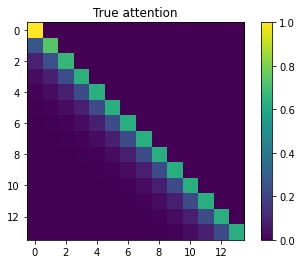

In [10]:
sns.reset_orig()
length = 15
plt.imshow(np.stack(padd_data(true_attention[0], length))[:, :length-1,0])
plt.colorbar()
plt.title('True attention')         #true attention

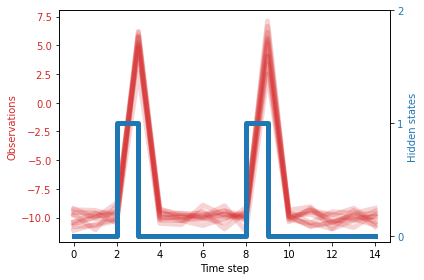

In [11]:
trajectory_index = 1

true_states[trajectory_index]


get_ipython().magic('matplotlib inline')

fig, ax1 = plt.subplots()

t = list(range(len(true_states[trajectory_index])))

color = 'tab:red'
ax1.set_xlabel('Time step')
ax1.set_ylabel('Observations', color=color)
ax1.plot(t, X_observations[trajectory_index], color=color, linewidth=5, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Hidden states', color=color)  
ax2.step(t, true_states[trajectory_index], color=color, linewidth=5)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yticks([0, 1, 2])

fig.tight_layout()  
plt.show()

#Code written by Ahmed M. Alaa reinplemented in Pytorch

In [12]:
class supplementary(nn.Module):
    def __init__(self, max_length, input_dim, state_dim,rnn_type, hidden_dim,attention_mode,lr,device):
        super(supplementary, self).__init__()

        self.max_len = max_length
        self.input_dim = input_dim
        self.state_dim = state_dim
        self.rnn_type = rnn_type
        self.hidden_dim = hidden_dim

        self.lr = lr
        self.device = device
        self.loss_list = []

        self.attention_mode = attention_mode

        if self.attention_mode == 1:
            self.encoder_lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, batch_first = True).to(self.device) 
            self.decoder_lstm = nn.LSTM(input_size=self.input_dim, hidden_size = self.hidden_dim, batch_first = True).to(self.device)
        elif self.attention_mode == 2:
            self.encoder = nn.LSTM(input_size = self.input_dim, hidden_size=self.hidden_dim, batch_first = True).to(self.device)
            self.decoder = nn.LSTMCell(input_size = self.hidden_dim, hidden_size = self.hidden_dim).to(self.device)


        self.dec_linear = nn.Linear(self.hidden_dim, 1).to(self.device)

        self.combiner1 = nn.Linear(self.input_dim, self.hidden_dim).to(self.device)
        self.combiner2 = nn.Linear(self.hidden_dim, self.state_dim).to(self.device)



        self.optimiser = torch.optim.Adam(self.parameters(), lr = self.lr)

    def gaussian_mixture(self, X):
        """
        Using Gaussian mixture to estimate the mean and covariance of gaussian components (latent discrete states) given the data X
        estimate the intial distribution and the transition matrix, note that the group label might not be correct but the set of probability tends
        to be accurate
        """
        num_component = self.state_dim
        self.GM = GaussianMixture(n_components = num_component, covariance_type = 'full')
        self.GM.fit(np.concatenate(X).reshape((-1, self.input_dim)))

        states_indicator =  [np.argmax(self.GM.predict_proba(X[i]), 1) for i in range(len(X))]      
                    #a list showing the belonging to states of each sequence of data
        
        #estimate the probability of initial distribution by looking at the entry at the first time step
        initial_states = np.array([states_indicator[i][0] for i in range(len(states_indicator))])
        init_probs = np.array([np.where(initial_states == i)[0].shape[0]/len(initial_states) for i in range(self.state_dim)])
                            #array showing the initial distribution of states

        self.state_trajectories = []
        for v in range(len(states_indicator)):
            state_list = [state_to_array(states_indicator[v][k], self.state_dim) for k in range(len(states_indicator[v]))]
            delayed_traject = np.vstack((np.array(state_list)[1:,:], np.array(state_list)[-1,:]))

            self.state_trajectories.append(delayed_traject)

        self.normaliser = StandardScaler()
        self.normaliser.fit(np.concatenate(X))

        self.X_normalised = []
        for k in range(len(X)):
            self.X_normalised.append(self.normaliser.transform(X[k]))


        #estimate baseline transition matrix
        P = np.zeros((self.state_dim, self.state_dim))
        each_state = np.zeros(self.state_dim)

        for i in range(len(states_indicator)):
            new_trans, new_each_state = get_transition(states_indicator[i], self.state_dim)
            P += new_trans
            each_state += new_each_state
        
        for j in range(self.state_dim):
            P[j,:] = P[j,:]/each_state[j]
            P[j,:] = P[j,:]/np.sum(P[j,:])

        return self.X_normalised

    def forward(self, X):

        self.data_preprocess(X)

        self.enc_inp = self.rnn_input.to(self.device)                       #[b*m, m, inp]
        self.dec_inp = torch.cat([torch.zeros(self.enc_inp.size(0), 1, self.enc_inp.size(-1)).to(self.device), 
                                  self.enc_inp[:,:-1,:]], 1)



        enc_out, (h, c) = self.encoder_lstm(self.enc_inp) 
        dec_out, _ = self.decoder_lstm(self.dec_inp, (h, torch.zeros_like(h).to(self.device)))        #[b*m, m, hid]

        self.seq2seq_attn = self.dec_linear(dec_out)        #[b*m, m, 1]
        self.seq2seq_attn = F.softmax(self.seq2seq_attn, dim = 1)      #[b*m,m,1]

        self.attention = self.seq2seq_attn
        attn_mask =     torch.sign(torch.abs(self.rnn_input).sum(2)).unsqueeze(-1)      #[b*m, m, 1]
        masked_attn = torch.multiply(attn_mask, self.attention)
        attn_norms = masked_attn.sum(1).repeat(1, self.max_len).unsqueeze(2)        
        self.attention = (masked_attn/attn_norms).repeat(1,1,self.input_dim)
        self.context = torch.multiply(self.attention, self.rnn_input).sum(1)        #[b*m, input]
        context_layer = self.combiner1(self.context)
        forward = F.softmax(self.combiner2(context_layer), dim = -1)        #[b*m, state_dim]

        forward = forward.reshape(-1, self.max_len, self.state_dim)     #[b, m, staet_dim]


        return forward
    
    def forward2(self,X):
        """
        Seq2Seq encoder-decoder attention, using its own decoder output as input
        """
        self.data_preprocess(X)
        self.enc_inp = self.rnn_input.to(self.device)
        enc_out, (h, c) = self.encoder(self.enc_inp)

        dec_out = torch.zeros_like(enc_out).to(self.device)
        dec_inp = torch.zeros(self.enc_inp.size(0), self.enc_inp.size(-1))      #[b*m, input_dim]
        pre_h = h.squeeze(0)
        pre_c = c.squeeze(0)
        for t in range(self.rnn_input.size(1)):
            h, c = self.decoder(dec_inp, (pre_h, pre_c))
            dec_out[:,t,:] = h
            pre_h, pre_c = h, c
            dec_inp = h
        
        self.seq2seq_attn = self.dec_linear(dec_out)        #[b*m, m, 1]
        self.seq2seq_attn = F.softmax(self.seq2seq_attn, dim = 1)      #[b*m,m,1]

        self.attention = self.seq2seq_attn
        attn_mask =     torch.sign(torch.abs(self.rnn_input).sum(2)).unsqueeze(-1)      #[b*m, m, 1]
        masked_attn = torch.multiply(attn_mask, self.attention)
        attn_norms = masked_attn.sum(1).repeat(1, self.max_len).unsqueeze(2)        
        self.attention = (masked_attn/attn_norms).repeat(1,1,self.input_dim)
        self.context = torch.multiply(self.attention, self.rnn_input).sum(1)        #[b*m, input]
        context_layer = self.combiner1(self.context)
        forward = F.softmax(self.combiner2(context_layer), dim = -1)        #[b*m, state_dim]

        forward = forward.reshape(-1, self.max_len, self.state_dim)     #[b, m, staet_dim]


        return forward

    
    def elbo(self, q, X, state):
        X = torch.tensor(X).float().to(self.device)
        state = torch.tensor(state).float().to(self.device)

        mask  = torch.sign(torch.abs(X).sum(2))
        flat_mask = mask.reshape(-1, 1)

        flat_state_guess = state.reshape(-1, self.state_dim)
        flat_forward = q.reshape(-1, self.state_dim)

        likelihood_loss = (-1*(flat_state_guess * torch.log(flat_forward))).sum()

        #length
        length = torch.sign(torch.abs(X).sum(2)).sum(1)


        likelihood_loss /= length.sum(0)

        return likelihood_loss


    def get_likelihood(self, X, pred):

        #X = X.to(self.device)
        pred = pred.cpu().data.numpy()

        likelihood = []

        XX = X.reshape((-1, self.input_dim))

        mean = self.GM.means_
        covars = self.GM.covariances_

        lks_ = np.array([multivariate_normal.logpdf(XX, mean[k], covars[k]).reshape((-1,1)) * pred[:,k].reshape((-1,1)) for k in range(self.state_dim)])
        
        return np.mean(lks_[np.isfinite(lks_)])



    def fit(self, X, epoch, batch_size):
        X = self.gaussian_mixture(X)

        X_ = np.array(padd_data(X, self.max_len))
        state_update = np.array(padd_data(self.state_trajectories, self.max_len))


        for e in range(epoch):

            batch_samples = np.random.choice(list(range(X_.shape[0])), size = batch_size, replace=False)
            batch_train = X_[batch_samples, :, :]
            batch_states = state_update[batch_samples, :, :]

            self.optimiser.zero_grad()
            
            if self.attention_mode == 1:
                batch_preds = self.forward(batch_train)     #[b, m, state]
            elif self.attention_mode == 2:
                batch_preds = self.forward2(batch_train)    #[b, m, state]

            loss = self.elbo(batch_preds,batch_train, batch_states)
            loss.backward()
            nn.utils.clip_grad_norm_(self.parameters(), 0.1)

            self.optimiser.step()
            
            self.loss_list.append(loss.data)

            log_like = np.array([self.get_likelihood(batch_train[k,:,:], batch_preds[k,:,:]) for k in range(batch_train.shape[0])])
            log_like = np.sum(log_like)/batch_size


            if e%50 == 0:
                print("Epoch: {}; loglike = {}".format(e+1, log_like))


    def predict(self, X):
        X_normalised = []
        for k in range(len(X)):
            X_normalised.append(self.normaliser.transform(X[k]))
        preds_lengths = [len(X_normalised[k]) for k in range(len(X_normalised))]

        X_pred = np.array(padd_data(X_normalised, self.max_len))
        
        if self.attention_mode == 1:
            prediction = self.forward(torch.tensor(X_pred).float()).reshape(-1, self.max_len, self.state_dim)
        elif self.attention_mode == 2:
            prediction = self.forward2(torch.tensor(X_pred).float()).reshape(-1, self.max_len, self.state_dim)


        preds = []
        obs = []

        for k in range(len(X)):
            preds.append(prediction[k,0:preds_lengths[k]].cpu().data.numpy())
            obs.append(self.get_observations(preds[-1]))

        att = self.attention
        attn_per_patient = [att[u*self.max_len : u*self.max_len + self.max_len, :, :] for u in range(len(X))]

        attn_lists_per_patient = [[attn_per_patient[u][k, 0:k+1, :] for k in range(self.max_len)] for u in range(len(X))]

        return (preds, obs, attn_lists_per_patient)

    def get_observations(self, preds):

        pred_obs = []
        for v in range(preds.shape[0]):
            observations = np.zeros(self.input_dim)

            for k in range(self.state_dim):
                observations += self.GM.means_[k] * preds[v,k]

            pred_obs.append(observations)
        return np.array(pred_obs)



    def data_preprocess(self, X):
        
        X = torch.tensor(X).float().to(self.device)
        num_sample = X.shape[0]

        conv_data = X.repeat(1, self.max_len, 1).reshape(self.max_len * num_sample, self.max_len, self.input_dim)
        conv_mask_ = torch.ones(self.max_len, self.max_len).float().to(self.device)
        conv_mask =   torch.tril(conv_mask_).repeat(num_sample, 1).unsqueeze(2).repeat(1,1,self.input_dim)

        masked_data = torch.multiply(conv_data, conv_mask)

        self.rnn_input = masked_data


In [14]:
original_model = supplementary(max_length=50, 
                               input_dim=10, 
                               state_dim=3,
                               rnn_type='LSTM', 
                               attention_mode = 1,
                               hidden_dim=64,
                               lr=1e-4,
                               device = 'cuda')

In [15]:
original_model.fit(X_observations, 1000, 100)

Epoch: 1; loglike = -247.95342663032056
Epoch: 51; loglike = -265.10468838627946
Epoch: 101; loglike = -281.26505883478933
Epoch: 151; loglike = -302.4981889824365
Epoch: 201; loglike = -336.07211707421516
Epoch: 251; loglike = -364.45866751971147
Epoch: 301; loglike = -389.44495938669644
Epoch: 351; loglike = -394.69803345996195
Epoch: 401; loglike = -427.2029055639931
Epoch: 451; loglike = -435.8286206521177
Epoch: 501; loglike = -446.0853850548265
Epoch: 551; loglike = -462.1939304702057
Epoch: 601; loglike = -464.7785101859869
Epoch: 651; loglike = -498.93811001266107
Epoch: 701; loglike = -479.33352478033504
Epoch: 751; loglike = -480.6612488822221
Epoch: 801; loglike = -468.24328790903843
Epoch: 851; loglike = -480.9136565853293
Epoch: 901; loglike = -480.83607123970035
Epoch: 951; loglike = -479.05919087280813


In [ ]:
plt.plot(original_model.loss_list)

In [ ]:
import seaborn as sns

Attention_weights = []
attention_weights = []

for w in range(len(attention[0])):

    q = attention[0][w][:,0].unsqueeze(-1)
    q2 = np.zeros((len(attention[0][-1]) - len(attention[0][w]),1))

    #print('q1 shape {}; q2 shape {}'.format(q.shape, q2.shape))
    temp = np.vstack((q.cpu().detach().numpy(), q2))
    #print(temp.shape)
    Attention_weights.append(temp)
    attention_weights.append(attention[0][w][:w+1, 0].detach().cpu().numpy())

print(np.array(Attention_weights).shape)
Attention_weights = np.array(Attention_weights).reshape((len(attention[0][-1]), len(attention[0][-1])))[:state[0].shape[0], :state[0].shape[0]]

mask = np.zeros_like(Attention_weights)

mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
    ax = sns.heatmap(Attention_weights, mask=mask, vmax=.3, square=True)
    ax.set_ylabel('Chronological time')
    ax.set_xlabel('Previous time steps')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (15,5))

length = 18
ax[0].imshow(np.stack(padd_data(true_attention[0], length))[:, :length-1,0])
ax[0].set_title('True attention')

im = ax[1].imshow(np.stack(padd_data(attention_weights[:length-1], length)).squeeze(-1)[:,:length-1])
ax[1].set_title('Predict attention');

fig.colorbar(im);

#Attentive state space model with posterior sampling (the one in the submitted report)

In [65]:

class attentive(nn.Module):
    def __init__(self, 
                 input_dim, 
                 state_dim, 
                 hidden_dim, 
                 max_length , 
                 attention_mode ,
                 lr ,
                 gumbel,
                 attention_flip,
                 normalise = True,
                 rnn_mode='LSTM', 
                 periodic_sampling=None,
                 rand_seed = 123,
                 resample = False,
                 local = None,
                 device = 'cuda'):
        """
        input_dim : the dimension of the observations
        state_dim : the number of latent discrete states
        hidden_dim: a list containing the hidden dimension for the encoder and the decoder, right now 
                    we assume they are the same, a linear layer can be put in between if they are different
        rnn_mode  : 'rnn', 'lstm' or 'gru'
        max_length: the maximum length for the data
        attention_mode:  different type of attention networks. 1: orignial attention in the paper
                                                               2: NLP attention
        gumbel: whether use Gumbel-Max trick
        periodic_sampling: if yes, input the time interval
        local:  whether use local attention, if yes, input a length for the window
        attention_flip: whether to flip the attention sequence
        resample: whether to resample particles during inference
        """
        
        super(attentive, self).__init__()

        self.input_dim = input_dim      #obs dim
        self.state_dim = state_dim      #latent discrete dim
        self.hidden_dim = hidden_dim    #rnn hidden dim
        self.forwRNN_hid = hidden_dim[0]
        self.backRNN_hid = hidden_dim[1]
        self.rnn_mode = rnn_mode
        self.max_len = max_length
        self.attention_mode = attention_mode
        self.lr = lr
        self.normalise = normalise
        self.seed = rand_seed
        self.device = device
        self.loss_list = []
        self.logprob_list = []
        self.kl_list = []

        self.valid_loss_list = []
        self.valid_logprob_list = []
        self.valid_kl_list = []

        self.gumbel = gumbel
        self.periodic_sampling = periodic_sampling
        self.local = local
        self.attention_flip = attention_flip
        self.resample = resample

        #seq2seq encoder and decoder and backward rnn
        if rnn_mode == 'RNN':
            if self.attention_mode == 1:
                self.encoder_rnn_cell = nn.RNNCell(input_size = self.input_dim, hidden_size=self.forwRNN_hid)
                self.decoder_rnn_cell = nn.RNNCell(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid)
            elif self.attention_mode == 2:
                self.encoder_rnn = nn.RNN(input_size = self.input_dim, hidden_size=self.forwRNN_hid, batch_first=True)
                #self.decoder_rnn = nn.RNN(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid, batch_first=True)

            self.backward_rnn = nn.RNN(input_size = self.input_dim, hidden_size = self.backRNN_hid, batch_first=True)

        elif rnn_mode == 'LSTM':
            if self.attention_mode == 1:
                self.encoder_rnn_cell = nn.LSTMCell(input_size = self.input_dim, hidden_size=self.forwRNN_hid).to(self.device)
                self.decoder_rnn_cell = nn.LSTMCell(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid).to(self.device)
            elif self.attention_mode == 2:
                self.encoder_rnn = nn.LSTM(input_size = self.input_dim, hidden_size = self.forwRNN_hid, batch_first=True).to(self.device)
            #self.decoder_rnn = nn.LSTM(input_size = self.input_dim, hidden_size = self.forwRNN_hid, batch_first = True)
            #self.decoder_rnn = nn.LSTM(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid, batch_first=True)

            self.backward_rnn = nn.LSTM(input_size = self.input_dim, hidden_size = self.backRNN_hid, batch_first=True).to(self.device)


        elif rnn_mode == 'GRU':
            if self.attention_mode == 1:
                self.encoder_rnn_cell = nn.GRUCell(input_size = self.input_dim, hidden_size=self.forwRNN_hid)
                self.decoder_rnn_cell = nn.GRUCell(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid)
            elif self.attention_mode == 2:
                self.encoder_rnn = nn.GRU(input_size = self.input_dim, hidden_size = self.forwRNN_hid, batch_first=True)
            #self.decoder_rnn = nn.GRU(input_size = self.forwRNN_hid, hidden_size = self.forwRNN_hid, batch_first=True)
            
            self.backward_rnn = nn.GRU(input_size = self.input_dim, hidden_size = self.backRNN_hid, batch_first=True)

        if self.attention_mode == 1:
            
            init_lstm_wt(self.encoder_rnn_cell, seed = self.seed)
            init_lstm_wt(self.decoder_rnn_cell, seed = self.seed)
        elif self.attention_mode == 2:
        #    init_lstm_wt(self.encoder_rnn, seed = self.seed)
            #init_lstm_wt(self.decoder_rnn, seed = self.seed)

            self.W_h = nn.Linear(self.forwRNN_hid, self.forwRNN_hid, bias = False).to(self.device)
            self.W_e = nn.Linear(self.forwRNN_hid, self.forwRNN_hid, bias = True).to(self.device)
            self.v = nn.Linear(self.forwRNN_hid, 1, bias = False).to(self.device)

            init_linear_wt(self.W_h, seed = self.seed)
            init_linear_wt(self.W_e, seed = self.seed)
            init_linear_wt(self.v, seed = self.seed)


        self.encoder_out_linear = nn.Sequential(
            nn.Linear(self.forwRNN_hid, self.forwRNN_hid),
            nn.ReLU()
        ).to(self.device)           #input: last hidden state of encoder, output: encoder output

        init_linear_wt(self.encoder_out_linear[0], seed = self.seed)

        #seq2seq softmax layer
        self.attention_linear = nn.Sequential(
            nn.Linear(self.forwRNN_hid, self.forwRNN_hid),
            nn.ReLU(),
            nn.Linear(self.forwRNN_hid, 1),
            nn.Softmax(1)
        ).to(self.device)           #softmax with axis 1 as we are normalising over the length of sequence

        init_linear_wt(self.attention_linear[0], self.seed)

        #combiner function
        self.combiner = nn.Sequential(
            nn.Linear(self.backRNN_hid+self.state_dim, self.state_dim),  
            nn.Tanh(),
            nn.Linear(self.state_dim, self.state_dim),       
            nn.Softmax(-1)
        ).to(self.device)                   #directly concatenate the backward hidden state and the posterior

        #self.combiner_p = nn.Linear(self.state_dim, self.state_dim).to(self.device)
        #self.combiner_b = nn.Linear(self.backRNN_hid, self.state_dim, bias = False).to(self.device)

        init_linear_wt(self.combiner[0], self.seed)

        self.optimiser = torch.optim.Adam(self.parameters(), lr = self.lr)


    def gaussian_mixture(self, X):
        """
        Using Gaussian mixture to estimate the mean and covariance of gaussian components (latent discrete states) given the data X
        estimate the intial distribution and the transition matrix, note that the group label might not be correct but the set of probability tends
        to be accurate
        """
        num_component = self.state_dim
        self.GM = GaussianMixture(n_components = num_component, covariance_type = 'diag')
        self.GM.fit(np.concatenate(X).reshape((-1, self.input_dim)))

        states_indicator =  [np.argmax(self.GM.predict_proba(X[i]), 1) for i in range(len(X))]      
                    #a list showing the belonging to states of each sequence of data
        
        #estimate the probability of initial distribution by looking at the entry at the first time step
        initial_states = np.array([states_indicator[i][0] for i in range(len(states_indicator))])
        init_probs = np.array([np.where(initial_states == i)[0].shape[0]/len(initial_states) for i in range(self.state_dim)])
                            #array showing the initial distribution of states

        self.state_trajectories = []
        for v in range(len(states_indicator)):
            state_list = [state_to_array(states_indicator[v][k], self.state_dim) for k in range(len(states_indicator[v]))]
            delayed_traject = np.vstack((np.array(state_list)[1:,:], np.array(state_list)[-1,:]))

            self.state_trajectories.append(delayed_traject)     #estiamte latent states from GM

        #estimate baseline transition matrix
        P = np.zeros((self.state_dim, self.state_dim))
        each_state = np.zeros(self.state_dim)

        for i in range(len(states_indicator)):
            new_trans, new_each_state = get_transition(states_indicator[i], self.state_dim)
            P += new_trans
            each_state += new_each_state
        
        for j in range(self.state_dim):
            P[j,:] = P[j,:]/each_state[j]
            P[j,:] = P[j,:]/np.sum(P[j,:])
        

        self.pi = torch.tensor(init_probs).float().to(self.device)    #initial distribution

        #self.P = nn.Parameter(torch.tensor(np.array(P)).float().clone().requires_grad_(True)).to(self.device)

        self.P = torch.tensor(np.array(P)).float().to(self.device)    #baseline transition matrix

    def nlp_attention(self, X, X_mask, true_length):
        """
        This type of attention is widely-used in NLP literature  tanh(W*h_{1:T-1}+W*h_T + b)
        X : [batch*(max_len-1), max_len, input_dim]
        X_mask : [batch*(max_len-1), max_len, 1]
        """

        X = X.to(self.device)
        X_mask = X_mask.to(self.device)
        batch_size = X.size(0)
        attention_container = torch.zeros(batch_size, self.max_len-1, 1)
        init_h = torch.zeros(1, batch_size, self.forwRNN_hid).to(self.device)
        if self.rnn_mode == 'LSTM':
            init_c = torch.zeros_like(init_h).to(self.device)
        enc_out, (h,_) = self.encoder_rnn(X, (init_h, init_c))      #[batch*max_len-1, max_len ,hidden]
        e_t = self.W_h(enc_out[:,:-1,:])        #[batch*max_len-1, max-len-1, hidden]
        true_last_hidden = torch.zeros(batch_size, self.forwRNN_hid).to(self.device)
        for i in range(batch_size):
            true_last_hidden[i,:] = enc_out[i, int(true_length[i])-1, :]
        fea = self.W_e(true_last_hidden)

        e_t = e_t + fea.unsqueeze(1)
        e_t = self.v(torch.tanh(e_t))
        e_t = F.softmax(e_t.squeeze(-1), 1)

        masked_attention = e_t.unsqueeze(-1) * X_mask[:,1:,:]
        masked_attention = masked_attention/torch.sum(masked_attention, axis = 1, keepdim = True)

        return masked_attention




    def target_attention(self, X, X_mask,true_length, b_z):
        """
        The same attention network as the paper. the decoder takes output at previous time step as
        current input. Therefore, the attention acts like a target label to be learnt.

        Note that the attention weights are updated at each time step. Therefore we feed same data
        with increasing length to the network and obtain attention with length (len-1)

        X           : the input data with shape [batch*(max_len-1), max_len, input_dim]
        X_mask      : mask for X, [batch*(max_len-1), max_len, 1]
        true_length : an array containing the true length of the padded data sequence
        b_z         : batch_size, only used for local attention

        return 
        masked attention: [batch*(max_len-1), max_len-1, 1]

        """
        X = X.to(self.device)
        X_mask = X_mask.to(self.device)
        batch_size = X.size(0)          #[batch*max_len-1]

        #if self.rnn_mode == 'LSTM':
        #    init_h = torch.zeros(1, batch_size, self.forwRNN_hid)
        #    init_c = torch.zeros_like(init_h)

        #    encoder_out, (h_t, c_t) = self.encoder_rnn(X, (init_h, init_c))  #[batch, max_seq, hidden]
        #else:
        #    init_h = torch.zeros(1, batch_size, self.forwRNN_hid)
        #    encoder_out, h_t = self.encoder_rnn(X, init_h)
        
        #pick the last hidden state for the decoder, using the data masking
        #masked_hidden = torch.stack([encoder_out[i][int(true_length[i])-1,:] for i in range(encoder_out.size(0))]).unsqueeze(0)    #index need -1
                                                            #[1,batch, hidden]

        #cell style
        init_h = torch.zeros(batch_size, self.forwRNN_hid).to(self.device)
        enc_h_container = torch.zeros(batch_size, self.max_len, self.forwRNN_hid).to(self.device)
        previous_h = init_h

        if self.rnn_mode == 'LSTM':
            init_c = torch.zeros_like(init_h).to(self.device)
            enc_c_container = torch.zeros(batch_size, self.max_len, self.forwRNN_hid).to(self.device)
            previous_c = init_c
        
        for t in range(self.max_len):
            if self.rnn_mode == 'LSTM':

                temp_h, temp_c = self.encoder_rnn_cell(X[:,t,:], (previous_h, previous_c))
                enc_h_container[:,t,:] = temp_h
                enc_c_container[:,t,:] = temp_c

                previous_h, previous_c = temp_h, temp_c

            else:
                temp_h = self.encoder_rnn_cell(X[:,t,:], previous_h)
                enc_h_container[:,t,:] = temp_h

                previous_h = temp_h

        #pick the last hidden state according to the true length of the original data
        masked_hidden = torch.stack([enc_h_container[i][int(true_length[i])-1,:] for i in range(batch_size)])       #[batch, hidden]
        if self.rnn_mode == 'LSTM':
            masked_c = torch.stack([enc_c_container[i][int(true_length[i])-1,:] for i in range(batch_size)])


        #and the input for the decoder
        O = self.encoder_out_linear(masked_hidden)      #[1, batch, hidden]


        #decoder, also need to run rnncell iteratively
        dec_h_container = torch.zeros(batch_size, self.max_len-1, self.forwRNN_hid) .to(self.device)  
        previous_h =  masked_hidden
        if self.rnn_mode == 'LSTM':
            #dec_c_container = torch.zeros_like(h_container)
            previous_c = masked_c

        dec_input = O
        for t in range(self.max_len-1):
            if self.rnn_mode == 'LSTM':
                temp_h, temp_c = self.decoder_rnn_cell(dec_input, (previous_h, previous_c))
                dec_h_container[:,t,:] = temp_h

                previous_h, previous_c = temp_h, temp_c
                dec_input = temp_h      #feeding its own output to the itself
            else:
                temp_h = self.decoder_rnn_cell(dec_input, previous_h)
                dec_h_container[:,t,:] = temp_h

                previous_h = temp_h
                dec_input = temp_h

        #softmax on h
        attention_weights = self.attention_linear(dec_h_container)      #[batch, self.max_len-1, 1]

        #masking the attention weight
        masked_attention = torch.multiply(attention_weights, X_mask[:,1:,:])     #start fron the second observation
        masked_attention = masked_attention/torch.sum(masked_attention, axis = 1, keepdims=True)        #zero out others


        if self.local is not None:
            for b in range(b_z):
                masked_attention[b*(self.max_len-1):(b+1)*(self.max_len-1),:,0] *= torch.tril(torch.ones(self.max_len-1, 
                                                                                                        self.max_len-1), self.local-1).T.float().to(self.device) #local_mask.to(self.device)

            masked_attention = masked_attention/torch.sum(masked_attention, axis = 1, keepdim = True)

            return masked_attention



        
        if self.attention_flip:
            flipped_attention = torch.zeros_like(masked_attention).float().to(self.device)
            for i in range(masked_attention.size(0)):
                flipped_attention[i, :int(true_length[i])-1,:] = masked_attention[i,:int(true_length[i])-1,:].flip(0,1)

            #self.flip_att = flipped_attention
            #return attention_weights
            return flipped_attention
        else:
            return masked_attention         #[batch*(max_len), max_len, 1]


    def backward_network(self, reverse_X, reverse_X_mask):
        """
        Backward RNN outputting hidden representation of future observation X_{t:T}

        This use the padd data only, no need to stacked data. By running a backward RNN, we obtain  
        sequences of hidden representation, masking is needed

        reverse_X   : [batch, max_len, input_dim]
        return
        masked_backward_out : [batch, max_len, hidden] note that the order is in reverse
        """
        reverse_X = reverse_X.to(self.device)
        reverse_X_mask = reverse_X_mask.to(self.device)

        batch_size = reverse_X.shape[0]

        initial_h = torch.zeros(1, batch_size, self.backRNN_hid).to(self.device)
        if self.rnn_mode == 'LSTM':
            initial_c = torch.zeros_like(initial_h).to(self.device)
            backward_out, (h, c) = self.backward_rnn(reverse_X, (initial_h, initial_c))     #[batch, max_len, hidden]
        else:
            backward_out, h = self.backward_rnn(reverse_X, initial_h)


        masked_backward_out = torch.multiply(backward_out, reverse_X_mask)        #[batch, max_len, hidden]

        return masked_backward_out




    def batched_inference(self, all_attention, backward_hidden, reverse_X_length, padd_mask,
                          sample_size, gumbel):
        """
        sampling in batches

        all_attention: [batch*(max_len-1), max_len-1, 1]
        backward_hidden: [batch, max_len, hidden]
        """
        gumbel = self.gumbel

        padd_mask = padd_mask.to(self.device)

        batch_size = backward_hidden.size(0)

        p_forward_container = torch.zeros(batch_size*sample_size, self.max_len, self.state_dim).to(self.device)
        gumbel_hard_container = torch.zeros(batch_size*sample_size, self.max_len, self.state_dim).to(self.device)
        q_container = torch.zeros(batch_size*sample_size, self.max_len, self.state_dim).to(self.device)
        z_sample_container = torch.zeros(batch_size*sample_size, self.max_len, 1).to(self.device)

        p1 = self.pi.repeat(batch_size*sample_size, 1)
        p_forward_container[:,0,:] = p1
        q_container[:,0,:] = p1
        multi_t1 = Multinomial(1, p1)
        z1_mask = multi_t1.sample()
        gumbel_hard_container[:,0,:] = z1_mask
        z1 = torch.argmax(z1_mask, -1)
        
        z_sample_container[:,0,0]=z1

        #self.log_att = []
        #self.back = []
        #self.nextp = []
        #self.log_gum = []


        for t in range(1,self.max_len):
            current_backward_hid = torch.stack([backward_hidden[b, int(reverse_X_length[b])-1-t, :] for b in range(batch_size)])        #
                                    #[batch, hidden]
            sample_backward_hid = current_backward_hid.repeat(1,sample_size).reshape(-1, self.backRNN_hid)  #[batch*sample, hidd]
            assert sample_backward_hid.shape == (batch_size*sample_size, self.backRNN_hid)

            current_attention = torch.stack([all_attention[b*(self.max_len-1)+t-1,:,:] for b in range(batch_size)])     
                            #[batch, max_len-1, 1], true length = t

            assert current_attention.shape == (batch_size, self.max_len-1, 1)
            sample_attention = current_attention.squeeze(-1).repeat(1,sample_size).reshape(-1, self.max_len-1).unsqueeze(-1)
                                        #[batch*sample, max_len-1, 1]

            #self.log_att.append(sample_attention)
            #self.back.append(sample_backward_hid)
            #self.log_gum.append(gumbel_hard_container[:,:-1,:].data.cpu().numpy())
            #print('gum = ', gumbel_hard_container[0,:,:])
            #P = F.softmax(self.P, -1)
            next_p = torch.matmul(gumbel_hard_container[:,:-1,:],   self.P)   
                    #[batch*sample, max_len-1, state_dim]* [state_dim, state_dim]= [batch*sample, max_len-1, state_dim]
                                #true length t
            if t == 1:
                sample_attention = sample_attention.detach()
            next_p = torch.multiply(next_p, sample_attention.repeat(1,1,self.state_dim))   #[batch*sample, max_len-1, staet_dim]
            next_p = next_p.sum(1)      #[batch*sample, state_dim]
            next_p = next_p/next_p.sum(-1, keepdim = True)
            #self.next_p = next_p
            #assert torch.all(next_p.sum(-1) == 1)

            p_forward_container[:,t,:] = next_p

            #q_t = self.combiner_p(next_p) + self.combiner_b(sample_backward_hid)
            #q_t = F.softmax(q_t,-1)

            h_q = torch.cat([sample_backward_hid, next_p], -1)        #[batch*sample, hidden+staet_dim]
            assert h_q.shape == (batch_size*sample_size, self.backRNN_hid+self.state_dim)
            q_t = self.combiner(h_q)        #[batch_size, state_dim]
            #q_t = torch.softmax(self.combiner_b(sample_backward_hid) + self.combiner_p(next_p), -1)

            q_container[:,t,:]= q_t

            if self.resample:
                mean_qt = q_t.reshape(batch_size, sample_size,  self.state_dim).mean(1)
                resample_qt = mean_qt.repeat(1,sample_size).reshape(batch_size*sample_size, self.state_dim)
                q_t =resample_qt


            if self.periodic_sampling is not None:
                
                if t % self.periodic_sampling ==0:
                    zt_mask =Multinomial(1, q_t).sample()
                else:
                    zt_mask = F.gumbel_softmax(q_t, hard=True)
            else:

                if gumbel:
                    zt_mask = F.gumbel_softmax(q_t, hard=True)
                else:
                    zt_mask = Multinomial(1, q_t).sample()

            gumbel_hard_container[:,t,:]=zt_mask
            zt = torch.argmax(zt_mask, -1)
            z_sample_container[:,t,0] = zt


        mean_gumbel = gumbel_hard_container.reshape(batch_size, sample_size, 
                                                              self.max_len, self.state_dim).mean(1) #[batch_size, self.max_len, state_dim]
        
        #mean_p = p_forward_container.reshape(batch_size, sample_size, self.max_len, self.state_dim).mean(1)
        #mean_q = q_container.reshape(batch_size, sample_size, self.max_len, self.state_dim).mean(1)
        q_entropy = (q_container * torch.log(q_container)).reshape(batch_size, sample_size, self.max_len, self.state_dim).mean(1)
        p_entropy = (q_container * torch.log(p_forward_container)).reshape(batch_size, sample_size, self.max_len, self.state_dim).mean(1)
        
        KL = q_entropy - p_entropy
        

        self.gumbel_hard_container = mean_gumbel #gumbel_hard_container
        #self.p_forward_container = mean_p
        #self.q_container = mean_q
        self.KL = KL
        #self.p_forward_container = p_forward_container
        #self.q_container = q_container
        self.z_sample_container = z_sample_container
        self.mean_q = q_container.reshape(batch_size, sample_size, self.max_len, self.state_dim).mean(1)

        #self.masked_mean_q = (q_container*gumbel_hard_container).reshape(batch_size, sample_size, self.max_len,
        #                                                                 self.state_dim).mean(1)



    def generating(self):
        """
        After the posterior inference, we obtain seqeunes of latent state samples and probabilities scores, from which we can reconstruct observation
        so that the gradient can be computed and backproppogated back to the model parameters, the emission mean and covariance come from the Gaussian
        mixture estimation

        the reconstructed mean is computed as probs*emission_mean, the emission variance is the same
        """     

        multiplier = self.mean_q #self.gumbel_hard_container  #self.mean_q        #self.gumbel_hard_container
        
        expected_mean = multiplier @ torch.tensor(self.GM.means_).float().to(self.device)
                        #[batch, max_len, state_dim]
        expected_covariance = torch.pow(multiplier, 2) @ torch.tensor(self.GM.covariances_).float().to(self.device)

        return expected_mean, expected_covariance
        #return expected_mean, expected_covariance

    def elbo(self, mean, covariance, X_padded, X_length):

        batch_size = mean.size(0)

        mean = mean.to(self.device)
        covariance = covariance.to(self.device)
        X_padded = X_padded.to(self.device)

        #logprob
        logprob_sum = 0
        #post_logprob_sum = 0
        #tran_logprob_sum = 0
        kl_sum = 0

        for b in range(batch_size):
            for t in range(self.max_len):
            #for t in range(int(X_length[b])):
                multinormal = MultivariateNormal(mean[b,t,:], torch.diag(covariance[b,t,:]))
                logprob_sum += multinormal.log_prob(X_padded[b,t,:])

        kl = self.KL.sum()

        elbo = logprob_sum  - kl
                

        return elbo/batch_size, logprob_sum.data/batch_size, kl.data/batch_size#self.KL.data/batch_size



    def train_one_epoch(self):
        """
        for external training purpose
        """

        pass

    def fit(self, X, epoch, batch_size, mc_sample_size, validation,retrain):
        #X = X.to(self.device)
        gumbel = self.gumbel

        if not retrain:
            
            if validation:
                length = len(X)
                split = int(length/20)
                train = X[:-split]
                valid = X[-split:]
                X = train
            else:
                pass

            self.gaussian_mixture(X)


            original_X = torch.tensor(np.stack(padd_data(X, self.max_len))).float()
            if validation:
                original_valid = torch.tensor(np.stack(padd_data(valid, self.max_len))).float()
        #state_update = np.array(padd_data(self.state_trajectories, self.max_len))


            if self.normalise:
                X = self.data_normalisation(X)

                if validation:
                    normalised_valid = []
                    for i in range(len(valid)):
                        normalised_valid.append(self.normaliser.transform(valid[i]))
                    valid = normalised_valid

            reverse_X = []
            for i in range(len(X)):
                reverse_X.append(np.flip(X[i], 0))
            
            if validation:
                reverse_valid = []
                for i in range(len(valid)):
                    reverse_valid.append(np.flip(valid[i], 0))

            X = np.stack(padd_data(X, self.max_len))       #[total_num, max_len, input_dim]
            reverse_X = np.stack(padd_data(reverse_X, self.max_len))        #[total_num, max_len, input_dim]

            if validation:
                valid = np.stack(padd_data(valid, self.max_len))
                reverse_valid = np.stack(padd_data(reverse_valid, self.max_len))
                self.original_valid = original_valid
                self.reverse_valid = reverse_valid
                self.valid = valid

            self.original_X = original_X
            self.X = X
            self.reverse_X = reverse_X


        else:
            original_X = self.original_X
            X = self.X
            reverse_X = self.reverse_X
            if validation:
                valid = self.valid
                reverse_valid = self.reverse_valid
                original_valid = self.original_valid

        #pre-process
        #self.padding(X, self.max_len)
        #self.stacking(self.X_padded, self.max_len)
        #self.reverse_padding(X, self.max_len)
        #self.feed2device()
        self.sample_size = mc_sample_size

        for e in range(epoch):
            print('Epoch {}'.format(e+1))
            idx = np.random.choice(list(range(X.shape[0])), size = batch_size, replace=False)
            batch_data = X[idx, :, :]           #[batch, max_len, input_dim]
            batch_reverse_data = reverse_X[idx, :, :]   
            batch_original_data = original_X[idx, :, :]
            #batch_states = state_update[idx, :, :]
            #batch_data = X
            #batch_reverse_data = reverse_X
            
            #data processing
            X_padded, X_mask, X_length = self.padding(batch_data, self.max_len, True)
            X_stack, X_stack_mask, X_stack_length = self.stacking(X_padded, self.max_len, True)
            reverse_X_padded, reverse_X_mask, reverse_X_length = self.reverse_padding(batch_reverse_data, self.max_len, True)


            self.optimiser.zero_grad()

            self.backhid = self.backward_network(reverse_X_padded, reverse_X_mask)           #backward hidden
        
            if self.attention_mode==1:
                self.att = self.target_attention(X_stack, X_stack_mask, X_stack_length, batch_size)     #attention
            elif self.attention_mode == 2:
                self.att = self.nlp_attention(X_stack, X_stack_mask, X_stack_length)

            self.batched_inference(self.att, self.backhid, reverse_X_length, X_mask, mc_sample_size, gumbel = gumbel)
            exp_mean, exp_cov = self.generating()

            FE, logprob, kl = self.elbo(exp_mean, exp_cov, batch_original_data, X_length)

            loss = -FE
            loss.backward()
            #nn.utils.clip_grad_norm_(self.parameters(), 0.1)
            self.optimiser.step()

            print('-----------------------------------------------------------------------------------')
            print('Training:')
            print('Loss = {}; logprob = {}; KL = {}'.format(loss.data, logprob, kl))
            self.loss_list.append(loss.data)
            self.logprob_list.append(logprob)
            self.kl_list.append(kl)

            if validation:
            #validation
                valid_padded, valid_mask, valid_length = self.padding(valid, self.max_len, False)
                valid_stack, valid_stack_mask, valid_stack_length = self.stacking(valid_padded, self.max_len, False)
                reverse_valid_padded, reverse_valid_mask, reverse_valid_length = self.reverse_padding(reverse_valid, self.max_len, False)
                valid_backhid = self.backward_network(reverse_valid_padded, reverse_valid_mask)           #backward hidden

                if self.attention_mode==1:
                    valid_att = self.target_attention(valid_stack, valid_stack_mask, valid_stack_length, batch_size)     #attention
                elif self.attention_mode == 2:
                    valid_att = self.nlp_attention(valid_stack, valid_stack_mask, valid_stack_length)

                self.batched_inference(valid_att, valid_backhid, reverse_valid_length, valid_mask, mc_sample_size, gumbel = gumbel)
                valid_exp_mean, valid_exp_cov = self.generating()

                valid_FE, valid_logprob, valid_kl = self.elbo(valid_exp_mean, valid_exp_cov, original_valid, valid_length)

                print('Valid:')
                print('Loss = {}; logprob = {}; KL = {}'.format(-valid_FE.data, valid_logprob.data, valid_kl.data))
                print('---------------------------------------------------------------------------------')
                self.valid_loss_list.append(-valid_FE.data)
                self.valid_logprob_list.append(valid_logprob.data)
                self.valid_kl_list.append(valid_kl.data)



        """
            #self.att = self.attention_network(self.X_stack, self.X_stack_length)
            mc_loss = 0
            mc_logprob = 0
            mc_kl = 0
            for _ in range(mc_sample_size):
                if self.gumbel:
                    self.inference_gumbel_network(self.att, backhid, reverse_X_length, X_stack_length)
                else:
                    self.inference_network(self.att, backhid, reverse_X_length)
                exp_mean, exp_cov = self.generating()

                #loss = self.new_elbo(self.prob_scores_container, batch_data, batch_states)

                FE, logprob, kl = self.elbo(exp_mean, exp_cov, batch_original_data, X_length)
                mc_loss -= FE
                mc_logprob += logprob
                mc_kl += kl

            mc_loss /= mc_sample_size
            mc_logprob /= mc_sample_size
            mc_kl /= mc_sample_size

            #if torch.isinf(mc_loss) or torch.isnan(mc_loss):
            #    continue

            mc_loss.backward()
            #loss.backward()
            #nn.utils.clip_grad_norm_(self.parameters(), 1)
            self.optimiser.step()

            print('Loss = {}; logprob = {}; KL = {}'.format(mc_loss.data, mc_logprob, mc_kl))
            #print('Loss = ',loss.data)
            self.loss_list.append(mc_loss.data)
            self.logprob_list.append(mc_logprob)
            self.kl_list.append(mc_kl)

        #return self.elbo(self.expected_mean, self.expected_covariance)
        #return self.backward_network(self.reverse_X_padded)
        #return self.attention_network(self.X_stack, self.X_stack_length)
        """
    def prediction(self, test_X):
        """
        text_X : a list of testing data
        """
        batch_size = len(test_X)
        if self.normalise:
            X_normalised = []
            for i in range(len(test_X)):
                X_normalised.append(self.normaliser.transform(test_X[i]))
            X = X_normalised
        X = np.stack(padd_data(X, self.max_len))
        X_padded, X_mask, X_length = self.padding(X, self.max_len)
        X_stack, X_stack_mask, X_stack_length = self.stacking(X_padded, self.max_len)
        if self.attention_mode == 1:
            self.test_att = self.target_attention(X_stack, X_stack_mask, X_stack_length, batch_size)     #attention
        elif self.attention_mode == 2:
            self.test_att = self.nlp_attention(X_stack, X_stack_mask, X_stack_length)

        return self.test_att

        """

        batch_size = X_padded.size(0)
        p_forward_container = torch.zeros(batch_size, self.max_len, self.state_dim).to(self.device)
        z_sample_container = torch.zeros(batch_size, self.max_len, 1).to(self.device)

        p1 = self.pi.repeat(batch_size, 1)
        p_forward_container[:,0,:] = p1

        multi_p1 = Multinomial(total_count = 1, probs = p1)
        z_1 = torch.argmax(multi_p1.sample())
        z_sample_container[:,0,:] = z_1.unsqueeze(-1)

        for b in range(batch_size):
            true_length = int(X_length[b])
            for t in range(1, true_length):
                temp_attention = self.test_att[b*(self.max_len-1)+t-1, :, :]
                #print('temp attention shape', temp_attention.shape)
                #print('z sample container shape', z_sample_container[b].shape)
                p_forward = self.z_transition(temp_attention, z_sample_container[b])
                p_forward_container[b,t,:] = p_forward

                multi_pt = Multinomial(total_count = 1, probs = p_forward)
                z_t = torch.argmax(multi_pt.sample())
                z_sample_container[b,t,:] = z_t
            
        expected_mean = p_forward_container @ torch.tensor(self.GM.means_).float().to(self.device)       #[batch, max_len, input]
        #expected_covariance = torch.pow(self.prob_scores_container, 2) @ torch.tensor(self.GM.covariances_).float().to(self.device)      #[batch, max_len, input]


        return z_sample_container, p_forward_container, expected_mean, self.test_att
        """



    def padding(self, X, max_len, record=None):
        """
        X : padded data [batch, max_length, inut]
        """
        #self.X_padded = np.stack(padd_data(X, max_len))       #[batch, max_len, input_dim]

        X_padded = X
        X_mask = np.expand_dims(np.sign(np.amax(np.abs(X_padded),2)), -1)     #[batch, max_len, 1]
        X_length = np.sign(np.amax(np.abs(X_padded), 2)).sum(1)       #1d array showing the ture sequence length of each batch
         
        X_padded = torch.tensor(X_padded).float()
        X_mask = torch.tensor(X_mask).float()
        X_length = torch.tensor(X_length).float()

        if record:
            self.X_padded = X_padded
            self.X_mask = X_mask
            self.X_length = X_length
        #else:
        return (X_padded, X_mask, X_length)
    
    def reverse_padding(self, X, max_len, record=None):

        #reverse_X = []
        #for i in range(len(X)):
        #    reverse_X.append(np.flip(X[i], 0))
        
        #self.reverse_X_padded = np.stack(padd_data(reverse_X, max_len))
        reverse_X_padded = X
        reverse_X_mask =  np.expand_dims(np.sign(np.amax(np.abs(reverse_X_padded), 2)), -1)
        reverse_X_length = np.sign(np.amax(np.abs(reverse_X_padded), 2)).sum(1)

        reverse_X_padded = torch.tensor(reverse_X_padded).float()  #[batch, max_len, input_di,]
        reverse_X_mask = torch.tensor(reverse_X_mask).float()       #[batch, max_len, 1]
        reverse_X_length = torch.tensor(reverse_X_length).float()

        if record:
            self.reverse_X_padded = reverse_X_padded
            self.reverse_X_mask = reverse_X_mask
            self.reverse_X_length = reverse_X_length
        #else:
        return reverse_X_padded, reverse_X_mask, reverse_X_length



    def stacking(self, X, max_len, record=None):
        """
        X : [batch, max_len, input_dim], padded data, in this version of stacking, we delete the sample with only one length, since we dont need attention 
        for sequence with length one, so np.tril(..., k =1)
        """
        batch_size = X.shape[0]

        conv_data = np.tile(X, [1, max_len-1, 1]).reshape([(max_len-1)*batch_size, max_len, self.input_dim])

        temp = np.ones([max_len-1, max_len])
        conv_mask = np.tile(np.expand_dims(np.tile(np.tril(temp, k =1), [batch_size, 1]), 2), [1,1,self.input_dim])

        stack_masked_data = np.multiply(conv_data, conv_mask)       #[batch*max_len-1, max_len, input]
        stack_masked_data_length = np.sign(np.amax(np.abs(stack_masked_data),2)).sum(1)

        X_stack = torch.tensor(stack_masked_data).float()
        X_stack_mask = torch.tensor(np.expand_dims(np.sign(np.amax(np.abs(stack_masked_data),2)),-1)).float()
        X_stack_length = torch.tensor(stack_masked_data_length).float()

        if record:
            self.X_stack = X_stack
            self.X_stack_mask = X_stack_mask
            self.X_stack_length = X_stack_length
        #else:
        return X_stack, X_stack_mask, X_stack_length




    def feed2device(self):
        self.X_padded = self.X_padded.to(self.device)
        self.X_mask = self.X_mask.to(self.device)
        self.X_stack = self.X_stack.to(self.device)
        self.X_stack_mask = self.X_stack_mask.to(self.device)
        self.reverse_X_padded = self.reverse_X_padded.to(self.device)
        self.reverse_X_mask = self.reverse_X_mask.to(self.device)


    def data_normalisation(self, X, record = None):
        """
        X : a list of unnormalised data
        """
        self.normaliser = StandardScaler()
        self.normaliser.fit(np.concatenate(X))

        X_normalised_list = []
        for i in range(len(X)):
            X_normalised_list.append(self.normaliser.transform(X[i]))
        if record:
            self.X_normalised_list = X_normalised_list

        return X_normalised_list




##Multinomial sampling 

In [36]:
m1 = attentive(input_dim = 10, 
              state_dim=3, 
              gumbel=False, 
              attention_flip=True,
              attention_mode=1, 
              max_length = 15, 
              lr = 1e-3, 
              hidden_dim = [64,64], 
              rand_seed = 123)

can run for multiple times to see the attentin at each epoch, make sure RETRAIN=True when you rerun it

In [37]:
m1.fit(X_observations,epoch=50, batch_size = 50, mc_sample_size=4000, retrain=False, validation = False)                                                     

Epoch 1
-----------------------------------------------------------------------------------
Training:
Loss = 20304.091796875; logprob = -20301.732421875; KL = 2.3597939014434814
Epoch 2
-----------------------------------------------------------------------------------
Training:
Loss = 19849.955078125; logprob = -19847.58984375; KL = 2.36513352394104
Epoch 3
-----------------------------------------------------------------------------------
Training:
Loss = 20209.171875; logprob = -20206.798828125; KL = 2.373122453689575
Epoch 4
-----------------------------------------------------------------------------------
Training:
Loss = 19857.607421875; logprob = -19855.2265625; KL = 2.3824992179870605
Epoch 5
-----------------------------------------------------------------------------------
Training:
Loss = 19802.8515625; logprob = -19800.458984375; KL = 2.3942384719848633
Epoch 6
-----------------------------------------------------------------------------------
Training:
Loss = 19670.105468

attention on unseen data

In [43]:
test_att0 = m1.prediction([test_observations[0]])
test_att1 = m1.prediction([test_observations[1]])
test_att2 = m1.prediction([test_observations[2]])

Text(0.5, 1.0, 'Predicted attention on testing data')

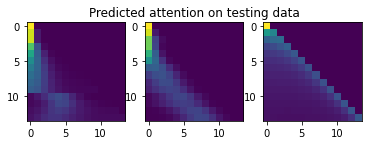

In [44]:
sns.reset_orig()            #50
fig, ax = plt.subplots(1,3)

ax[0].imshow(test_att0.squeeze().cpu().detach().numpy())
ax[1].imshow(test_att1.squeeze().cpu().detach().numpy())
ax[2].imshow(test_att2.squeeze().cpu().detach().numpy())

ax[1].set_title('Predicted attention on testing data')

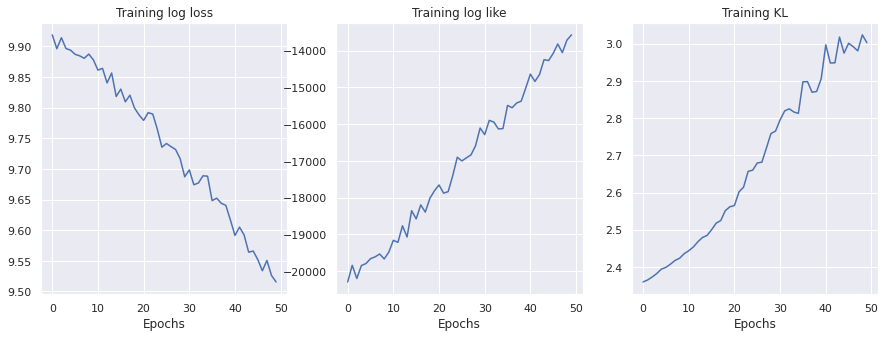

In [45]:

sns.set()


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(np.log(m1.loss_list), label = 'Train')
ax[1].plot(m1.logprob_list)
ax[2].plot(m1.kl_list)

#plt.plot(np.log(a.valid_loss_list), label = 'Valid')
ax[0].set_title('Training log loss')
ax[0].set_xlabel('Epochs')
ax[1].set_title('Training log like')
ax[1].set_xlabel('Epochs')
ax[2].set_title('Training KL')
ax[2].set_xlabel('Epochs');

##Gumbel-Max sampling

In [51]:
m2 = attentive(input_dim = 10, 
              state_dim=3, 
              gumbel=True, 
              attention_flip=True,
              attention_mode=1, 
              max_length = 15, 
              lr = 1e-3, 
              hidden_dim = [64,64], 
              rand_seed = 123)

In [52]:
m2.fit(X_observations,epoch=50, batch_size = 50, mc_sample_size=4000, retrain=False, validation = False)                                                     

Epoch 1
-----------------------------------------------------------------------------------
Training:
Loss = 20615.765625; logprob = -20613.611328125; KL = 2.1545228958129883
Epoch 2
-----------------------------------------------------------------------------------
Training:
Loss = 19758.662109375; logprob = -19756.50390625; KL = 2.1575686931610107
Epoch 3
-----------------------------------------------------------------------------------
Training:
Loss = 19905.94921875; logprob = -19903.787109375; KL = 2.1623873710632324
Epoch 4
-----------------------------------------------------------------------------------
Training:
Loss = 19649.20703125; logprob = -19647.03515625; KL = 2.1706748008728027
Epoch 5
-----------------------------------------------------------------------------------
Training:
Loss = 19822.861328125; logprob = -19820.68359375; KL = 2.175938606262207
Epoch 6
-----------------------------------------------------------------------------------
Training:
Loss = 20380.6113

In [53]:
test_att0 = m2.prediction([test_observations[0]])
test_att1 = m2.prediction([test_observations[1]])
test_att2 = m2.prediction([test_observations[2]])

Text(0.5, 1.0, 'Predicted attention on testing data')

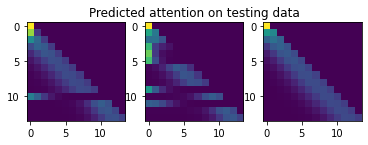

In [54]:
sns.reset_orig()            #50
fig, ax = plt.subplots(1,3)

ax[0].imshow(test_att0.squeeze().cpu().detach().numpy())
ax[1].imshow(test_att1.squeeze().cpu().detach().numpy())
ax[2].imshow(test_att2.squeeze().cpu().detach().numpy())

ax[1].set_title('Predicted attention on testing data')

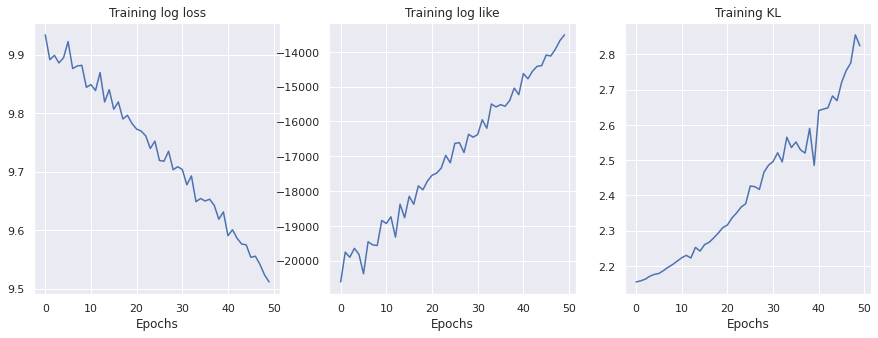

In [55]:

sns.set()


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(np.log(m2.loss_list), label = 'Train')
ax[1].plot(m2.logprob_list)
ax[2].plot(m2.kl_list)

#plt.plot(np.log(a.valid_loss_list), label = 'Valid')
ax[0].set_title('Training log loss')
ax[0].set_xlabel('Epochs')
ax[1].set_title('Training log like')
ax[1].set_xlabel('Epochs')
ax[2].set_title('Training KL')
ax[2].set_xlabel('Epochs');

##Periodic sampling

In [66]:
m3 = attentive(input_dim = 10, 
              state_dim=3, 
              gumbel=True, 
                periodic_sampling = 2,
              attention_flip=True,
              attention_mode=1, 
              max_length = 15, 
              lr = 1e-3, 
              hidden_dim = [64,64], 
              rand_seed = 123)

In [67]:
m3.fit(X_observations,epoch=50, batch_size = 50, mc_sample_size=4000, retrain=False, validation = False)                                                     

Epoch 1
-----------------------------------------------------------------------------------
Training:
Loss = 22726.77734375; logprob = -22722.912109375; KL = 3.865762233734131
Epoch 2
-----------------------------------------------------------------------------------
Training:
Loss = 21894.125; logprob = -21890.267578125; KL = 3.857182502746582
Epoch 3
-----------------------------------------------------------------------------------
Training:
Loss = 21885.03125; logprob = -21881.181640625; KL = 3.850864887237549
Epoch 4
-----------------------------------------------------------------------------------
Training:
Loss = 21687.88671875; logprob = -21684.037109375; KL = 3.8487565517425537
Epoch 5
-----------------------------------------------------------------------------------
Training:
Loss = 22222.814453125; logprob = -22219.0; KL = 3.8148443698883057
Epoch 6
-----------------------------------------------------------------------------------
Training:
Loss = 22378.5625; logprob = -2

In [68]:
test_att0 = m3.prediction([test_observations[0]])
test_att1 = m3.prediction([test_observations[1]])
test_att2 = m3.prediction([test_observations[2]])

Text(0.5, 1.0, 'Predicted attention on testing data')

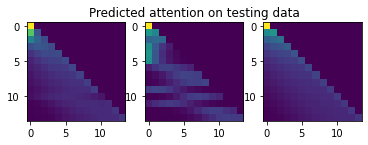

In [69]:
sns.reset_orig()            #50
fig, ax = plt.subplots(1,3)

ax[0].imshow(test_att0.squeeze().cpu().detach().numpy())
ax[1].imshow(test_att1.squeeze().cpu().detach().numpy())
ax[2].imshow(test_att2.squeeze().cpu().detach().numpy())

ax[1].set_title('Predicted attention on testing data')

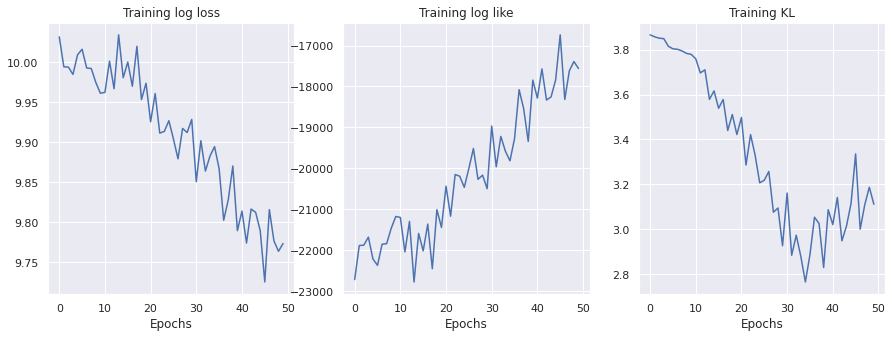

In [70]:

sns.set()


fig, ax = plt.subplots(1,3, figsize = (15,5))

ax[0].plot(np.log(m3.loss_list), label = 'Train')
ax[1].plot(m3.logprob_list)
ax[2].plot(m3.kl_list)

#plt.plot(np.log(a.valid_loss_list), label = 'Valid')
ax[0].set_title('Training log loss')
ax[0].set_xlabel('Epochs')
ax[1].set_title('Training log like')
ax[1].set_xlabel('Epochs')
ax[2].set_title('Training KL')
ax[2].set_xlabel('Epochs');